In [1]:
import scipy
import numpy as np

### Samples from von-Mises Fisher disribution

In [2]:
def random_VMF(mu, kappa, size=None):
    """
    VonMises-Fisherdistributionsamplerwith
    meandirectionmuandconcentrationkappa.
    Source:https://hal.science/hal-04004568
    """
    # parseinputparameters
    n = 1 if size is None else np.product(size)
    shape = () if size is None else tuple(np.ravel(size))
    mu = np.asarray(mu)
    mu = mu / np.linalg.norm(mu)
    (d,) = mu.shape
    # zcomponent:radialsamplesperpendiculartomu
    z = np.random.normal(0, 1, (n, d))
    z /= np.linalg.norm(z, axis=1, keepdims=True)
    z = z - (z @ mu[:, None]) * mu[None, :]
    z /= np.linalg.norm(z, axis=1, keepdims=True)
    # sample angles ( in cos and sin form )
    cos = _random_VMF_cos(d, kappa, n)
    sin = np.sqrt(1 - cos**2)
    # combineangleswiththezcomponent
    x = z * sin[:, None] + cos[:, None] * mu[None, :]
    return x.reshape((*shape, d))


def _random_VMF_cos(d: int, kappa: float, n: int):
    """
    G e n e r a t e n iid samples t with density f u n c t i o n given by
    p ( t ) = s o m e C o n s t a n t * (1 - t ** 2 ) **(( d - 2 ) / 2 ) * exp ( kappa * t )
    """
    # b = Eq . 4 of https :// doi . org / 10 . 1080 / 0 3 6 1 0 9 1 9 4 0 8 8 1 3 1 6 1
    b = (d - 1) / (2 * kappa + (4 * kappa**2 + (d - 1) ** 2) ** 0.5)
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (d - 1) * np.log(1 - x0**2)
    found = 0
    out = []
    while found < n:
        m = min(n, int((n - found) * 1.5))
        z = np.random.beta((d - 1) / 2, (d - 1) / 2, size=m)
        t = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        test = kappa * t + (d - 1) * np.log(1 - x0 * t) - c
        accept = test >= -np.random.exponential(size=m)
        out.append(t[accept])
        found += len(out[-1])
    return np.concatenate(out)[:n]

In [3]:
mu = np.array([0] * 511 + [1])
samples = random_VMF(mu, kappa=1000, size=100)

/tmp/ipykernel_69927/1317563471.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  samples = random_VMF(mu, kappa=1000, size=100)


In [4]:
samples.shape

(100, 512)

In [16]:
np.linalg.norm(samples, axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Calculate n-Sphere survace area
Survace of the sphere embedded in n-dimentional space is: 
$$
S_{n-1}(R) = \frac{2\,\pi^\frac{n}{2}}{\Gamma\left(\frac{n}{2}\right)}R^{n-1}
$$
we have R=1
$$
\log S_{n-1}(1) = \log(2) + \frac{n}{2}\log\pi - \log \Gamma\left(\frac{n}{2}\right)
$$

In [2]:
n = 512
log_S = np.log(2) + (n / 2) * np.log(np.pi) - scipy.special.loggamma(n / 2)
log_S

-867.9681031603942

In [3]:
from omegaconf import OmegaConf
from hydra.utils import instantiate
from evaluation.ijb_evals import instantiate_list
from evaluation.face_recognition_test import Face_Fecognition_test

cfg = OmegaConf.load("/app/configs/uncertainty_benchmark/ijb_evals.yaml")

# instantiate
open_set_identification_metrics = instantiate_list(cfg.open_set_identification_metrics)
open_set_uncertainty_metrics = instantiate_list(cfg.open_set_uncertainty_metrics)
closed_set_identification_metrics = instantiate_list(
    cfg.closed_set_identification_metrics
)
verification_metrics = instantiate_list(cfg.verification_metrics)

test_dataset = instantiate(cfg.test_dataset)

methods = []
method_types = []
if "open_set_identification_methods" in cfg:
    methods += cfg.open_set_identification_methods
    method_types += ["open_set_identification"] * len(
        cfg.open_set_identification_methods
    )
for method, method_type in zip(methods, method_types):
    evaluation_function = instantiate(method.evaluation_function)
    template_pooling = instantiate(method.template_pooling_strategy)
    tt = Face_Fecognition_test(
        evaluation_function=evaluation_function,
        test_dataset=test_dataset,
        embeddings_path=method.embeddings_path,
        template_pooling_strategy=template_pooling,
        use_detector_score=method.use_detector_score,
        use_two_galleries=cfg.use_two_galleries,
        recompute_template_pooling=cfg.recompute_template_pooling,
        open_set_identification_metrics=open_set_identification_metrics,
        closed_set_identification_metrics=closed_set_identification_metrics,
        verification_metrics=verification_metrics,
        open_set_uncertainty_metrics=open_set_uncertainty_metrics,
    )
    break

>>>> Reload from backup: /app/datasets/arcface_ijb/IJBC/backup.npz ...
>>>> Reload from backup: /app/datasets/arcface_ijb/IJBC/gallery_prob_backup.npz ...
>>>> Reload embeddings from: /app/datasets/arcface_ijb/IJBC/embeddings/scf_embs_IJBC.npz
>>>> process_embeddings: Norm False, Detect_score True, Flip False
Using detection score normalization


In [36]:
(
    g1_templates_feature,
    g1_template_unc,
    g1_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.g1_templates, tt.test_dataset.g1_ids)
print("g1_templates_feature:", g1_templates_feature.shape)  # (1772, 512)

(
    probe_templates_feature,
    probe_template_unc,
    probe_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.probe_templates, tt.test_dataset.probe_ids)
print("probe_templates_feature:", probe_templates_feature.shape)  # (19593, 512)

g1_templates_feature: (1772, 512)
probe_templates_feature: (19593, 512)


In [52]:
similarity = probe_templates_feature @ g1_templates_feature.T

In [54]:
gallery_ids_argsort = np.argsort(g1_unique_ids)
gallery_ids = g1_unique_ids[gallery_ids_argsort]
# if not labels_sorted:
similarity = similarity[:, gallery_ids_argsort]

is_seen = np.isin(probe_unique_ids, gallery_ids)
seen_sim: np.ndarray = similarity[is_seen]
imposter_sim: np.ndarray = similarity[~is_seen]

In [70]:
np.sum(is_seen), np.sum(~is_seen)

(9670, 9923)

In [71]:
9923 / (9923 + 9670)

0.5064563874853264

In [82]:
kappa = 500
hyp0f1(n, kappa**2 / 4, dtype=np.float64)

5.666170746317585e+80

In [75]:
1

1

In [57]:
from scipy.special import ive, hyp0f1, loggamma


def compute_log_z_prob(similarities, kappa, beta=0.5, n=256):
    K = similarities.shape[1]
    log_iv = np.log(ive(n - 1, kappa, dtype=np.float64)) + kappa
    log_c = (n - 1) * np.log(kappa) - n * np.log(2 * np.pi) - log_iv
    logit_sum = np.sum(np.exp(similarities * kappa), axis=1) * (1 - beta) / K
    # print(f'Logit sum: {logit_sum}')
    alpha_value = hyp0f1(n, kappa**2 / 4, dtype=np.float64)
    # print(f'Alpha value: {alpha_value}')
    log_z_prob = log_c + np.log(logit_sum + alpha_value * beta)
    # print(f'Log z prob: {log_z_prob}')
    return log_z_prob


def compute_uniform_aposteriory(similarities, kappa, beta=0.5, n=256):
    # compute log z prob
    log_z_prob = compute_log_z_prob(similarities, kappa, beta, n)
    # print(f'Log z prob: {log_z_prob}')
    log_uniform_dencity = loggamma(n, dtype=np.float64) - np.log(2) - n * np.log(np.pi)
    # print(f'Log uniform dencity: {log_uniform_dencity}')
    log_beta = np.log(beta)
    # print(f'Log beta : {log_beta}')
    log_prob = log_uniform_dencity + log_beta - log_z_prob
    # print(f'Log uniform prob: {log_prob}')
    return log_prob

In [61]:
kappa = 100
beta = 0.5
n = probe_templates_feature.shape[1] / 2
uniform_prob = compute_uniform_aposteriory(similarity, kappa, beta, n)

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt


def draw_score_distr_plot(
    scores_distr, score_type, model_name, in_data_name, out_data_name, fig_size
):
    sns.set_theme()
    plt.figure(figsize=fig_size)
    sns.distplot(
        scores_distr[in_data_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=in_data_name,
    )
    sns.distplot(
        scores_distr[out_data_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=out_data_name,
    )
    plt.xlabel(f"Косинусная схожесть")

    plt.legend()

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


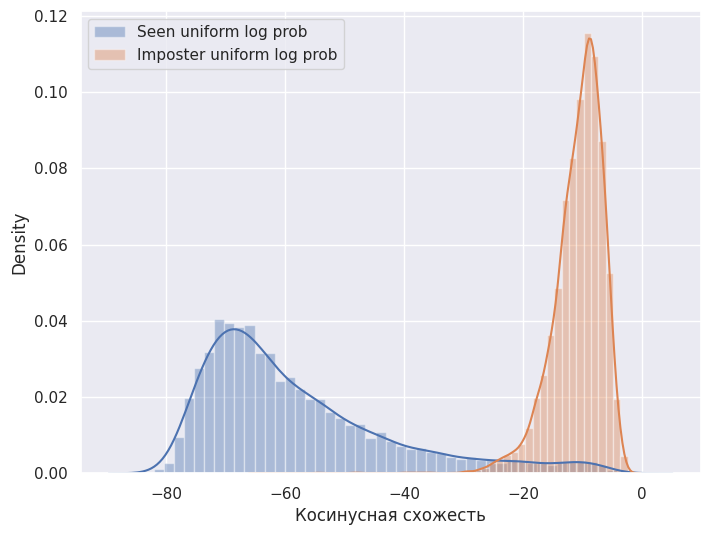

In [67]:
scores_distr = {
    "Seen uniform log prob": uniform_prob[is_seen],
    "Imposter uniform log prob": uniform_prob[~is_seen],
}

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="EVM",
    model_name="EVM",
    in_data_name="Seen uniform log prob",
    out_data_name="Imposter uniform log prob",
    fig_size=(8, 6),
)

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


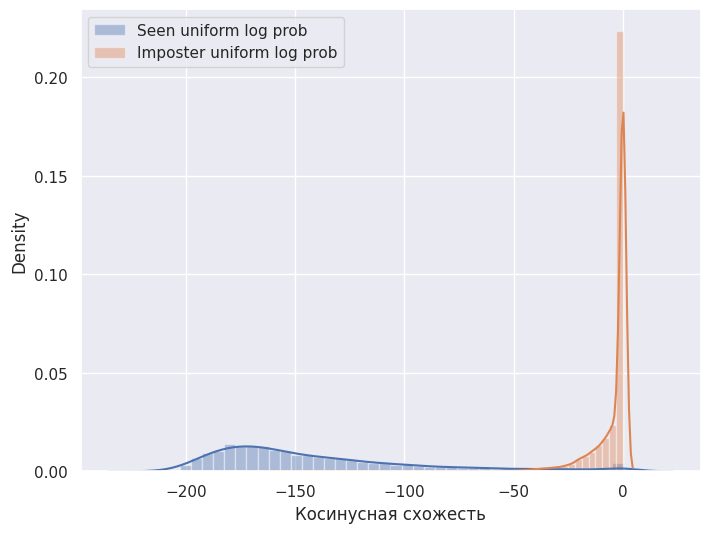

In [68]:
kappa = 300
beta = 0.5
n = probe_templates_feature.shape[1] / 2
uniform_prob = compute_uniform_aposteriory(similarity, kappa, beta, n)

scores_distr = {
    "Seen uniform log prob": uniform_prob[is_seen],
    "Imposter uniform log prob": uniform_prob[~is_seen],
}

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="EVM",
    model_name="EVM",
    in_data_name="Seen uniform log prob",
    out_data_name="Imposter uniform log prob",
    fig_size=(8, 6),
)